# Regional distribution of mutations across frequencies

In [21]:
from __future__ import division
import sys
import os
import time
import copy
import pickle

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# import logit scale
from LogitScale import *
mscale.register_scale(LogitScale)

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73"]

# Load data

In [22]:
# Sequences
df_seqs = pd.read_csv("data/df_seqs.filtered_V6_Full.csv", index_col=0)

In [23]:
# Mutation frequencies
freqs = pickle.load(open("data/SFS_Bulk_freqs.pickle"))
lineage_sizes = pickle.load(open("data/SFS_Bulk_lineage_sizes.pickle"))

# Functions to map mutations to regions, count occurrences

In [24]:
# Call region of mutation

def load_V_boundary_map(infile):
    """ Load map from V gene to boundary positions between CDR/FWR regions """
    M = {}
    with open(infile) as f:
        for line in f:
            vals = line.rstrip().split()
            name = vals[0]
            boundaries = map(int, vals[1:])
            M[name] = boundaries
    return M

def annotate_regions(freqs, df_raw, V_boundary_map):
    """ Annotate each mutation with its region (CDR/FWR) """
    
    start_time = time.time()
    
    bin_to_region = {1: "FWR1", 2: "CDR1", 3: "FWR2", 4: "CDR2", 5: "FWR3", 6: "CDR3"}
    
    freqs_annotated = {}
    
    for lineage_uid, muts in freqs.items():
        
        freqs_annotated[lineage_uid] = {}

        V_germline = df_raw[df_raw["lineage_uid"] == lineage_uid].iloc[0]["V_germline"] # get V germline
        boundaries = V_boundary_map[V_germline] # get boundaries of CDR/FWR

        for (gene_position, before, after), freq in muts.items():

            gene = gene_position[0]
            position = int(gene_position[1:])
            
            if gene == "V":
                my_bin = int(np.digitize(position, boundaries))
                region = bin_to_region[my_bin]
            elif gene == "D":
                region = "CDR3"
            elif gene == "J":
                region = "FWR4"
                
            key = (gene_position, before, after, region)
            freqs_annotated[lineage_uid][key] = freq

    elapsed_time = time.time() - start_time
    print "Wall clock time", elapsed_time
    print
    
    return freqs_annotated

def reshape_CDR_FWR_by_freq(freqs_regions, bins):
    """ Bin CDR/FWR calls by frequency of allele """
    
    regions = []
    for b in bins:
        regions.append([])
        
    count = 0
    for lineage_uid, muts in freqs_regions.items():
        for (gene_position, before, after, region), freq in muts.items():
            if freq >= bins[-1]:
                freq = bins[-1]
                count += 1
            my_bin = np.digitize(freq, bins, right=True)
            regions[my_bin].append(region)    
    return regions

def reshape_regions_to_df(regions_by_freq):
    df = pd.DataFrame(columns=["FWR1", "CDR1", "FWR2", "CDR2", "FWR3", "CDR3", "FWR4"], index=range(len(regions_by_freq)))
    for i in range(len(regions_by_freq)):
        names, counts = np.unique(regions_by_freq[i], return_counts=True)
        for name, count in zip(names, counts):
            df[name].loc[i] = count
    return df

import itertools
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return itertools.izip(a, b)

In [25]:
# Load boundaries of regions in V genes
infile_V_boundary_map = "data/Vsegments_20150201_boundaries.txt"
V_boundary_map = load_V_boundary_map(infile_V_boundary_map)

# Annotate each mutation with its region
freqs_regions = annotate_regions(freqs, df_seqs, V_boundary_map) # takes ~2 sec

Wall clock time 0.970833063126



In [26]:
# Choose bins for SFS
bins = np.array([1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999])
bin_centers_manual = np.array([5e-5, 5e-4, 5e-3, 5e-2, 0.25, 0.75, 1-5e-2, 1-5e-3, 1-5e-4, 1-5e-5])
bin_centers = np.sqrt(bins[1:] * bins[:-1])

In [27]:
# Bin mutations into regions
bins_for_regions = bins[2:-4]
bin_names = list(pairwise(bins_for_regions))
regions_by_freq = reshape_CDR_FWR_by_freq(freqs_regions, bins_for_regions)
df_mut_counts_by_region = reshape_regions_to_df(regions_by_freq)
df_mut_counts_by_region

,FWR1,CDR1,FWR2,CDR2,FWR3,CDR3,FWR4
0,1690,589,1346,831,3518,186,1203
1,4426,2775,3905,3715,11461,762,3099
2,2825,3249,3109,4376,10008,463,1754
3,770,1428,1074,1734,3719,151,500
4,102,270,164,290,502,26,68


In [28]:
# normalize
df_normed = df_mut_counts_by_region.div(df_mut_counts_by_region.sum(axis=1), axis=0)
df_normed

,FWR1,CDR1,FWR2,CDR2,FWR3,CDR3,FWR4
0,0.180498,0.0629072,0.143757,0.0887536,0.375734,0.0198654,0.128484
1,0.146833,0.0920612,0.129549,0.123246,0.380221,0.0252795,0.10281
2,0.109564,0.126008,0.120579,0.169718,0.388148,0.0179569,0.0680267
3,0.0821246,0.152304,0.114548,0.18494,0.396651,0.0161049,0.0533276
4,0.07173,0.189873,0.115331,0.203938,0.353024,0.0182841,0.04782


In [29]:
# label bins
df_normed_pretty = df_normed.loc[list(df_normed.index)[1:]]
df_normed_pretty["freq"] = map(str, bin_names)
df_normed_pretty.set_index("freq", drop=True, inplace=True)
df_normed_pretty.drop("CDR3", axis=1, inplace=True)
df_normed_pretty.sort_index(axis=1, inplace=True)

In [30]:
# calculate confidence intervals (95%)

from statsmodels.stats.proportion import proportion_confint

total_muts_binned = df_mut_counts_by_region.sum(axis=1) # total mutations in each frequency bin

regions = ["CDR1", "CDR2", "FWR1", "FWR2", "FWR3", "FWR4"]
df_normed_pretty_ciUpper = pd.DataFrame()
df_normed_pretty_ciLower = pd.DataFrame()
for region in regions:
    
    myUppers = []
    myLowers = []
    
    for i in df_mut_counts_by_region.drop(0).index:
        myCount = df_mut_counts_by_region[region].drop(0).loc[i]
        myTotal = total_muts_binned.loc[i]
        myConfInts = proportion_confint(myCount, myTotal)
        if np.isnan(myConfInts[0]) or np.isnan(myConfInts[1]) or np.isnan(df_normed_pretty[region].iloc[i-1]):
            myLower, myUpper = np.nan, np.nan
        else:
            myLower, myUpper = np.abs(myConfInts - df_normed_pretty[region].iloc[i-1])
        myUppers.append(myUpper)
        myLowers.append(myLower)

    df_normed_pretty_ciUpper[region] = myUppers
    df_normed_pretty_ciLower[region] = myLowers

In [31]:
# set index to frequency for plotting
df_normed_pretty["freq"] = bin_centers[2:-4]
df_normed_pretty.set_index("freq", inplace=True)
df_normed_pretty

,CDR1,CDR2,FWR1,FWR2,FWR3,FWR4
freq,,,,,,
0.003162,0.0920612,0.123246,0.146833,0.129549,0.380221,0.10281
0.031623,0.126008,0.169718,0.109564,0.120579,0.388148,0.0680267
0.223607,0.152304,0.18494,0.0821246,0.114548,0.396651,0.0533276
0.670820,0.189873,0.203938,0.07173,0.115331,0.353024,0.04782


# Plot

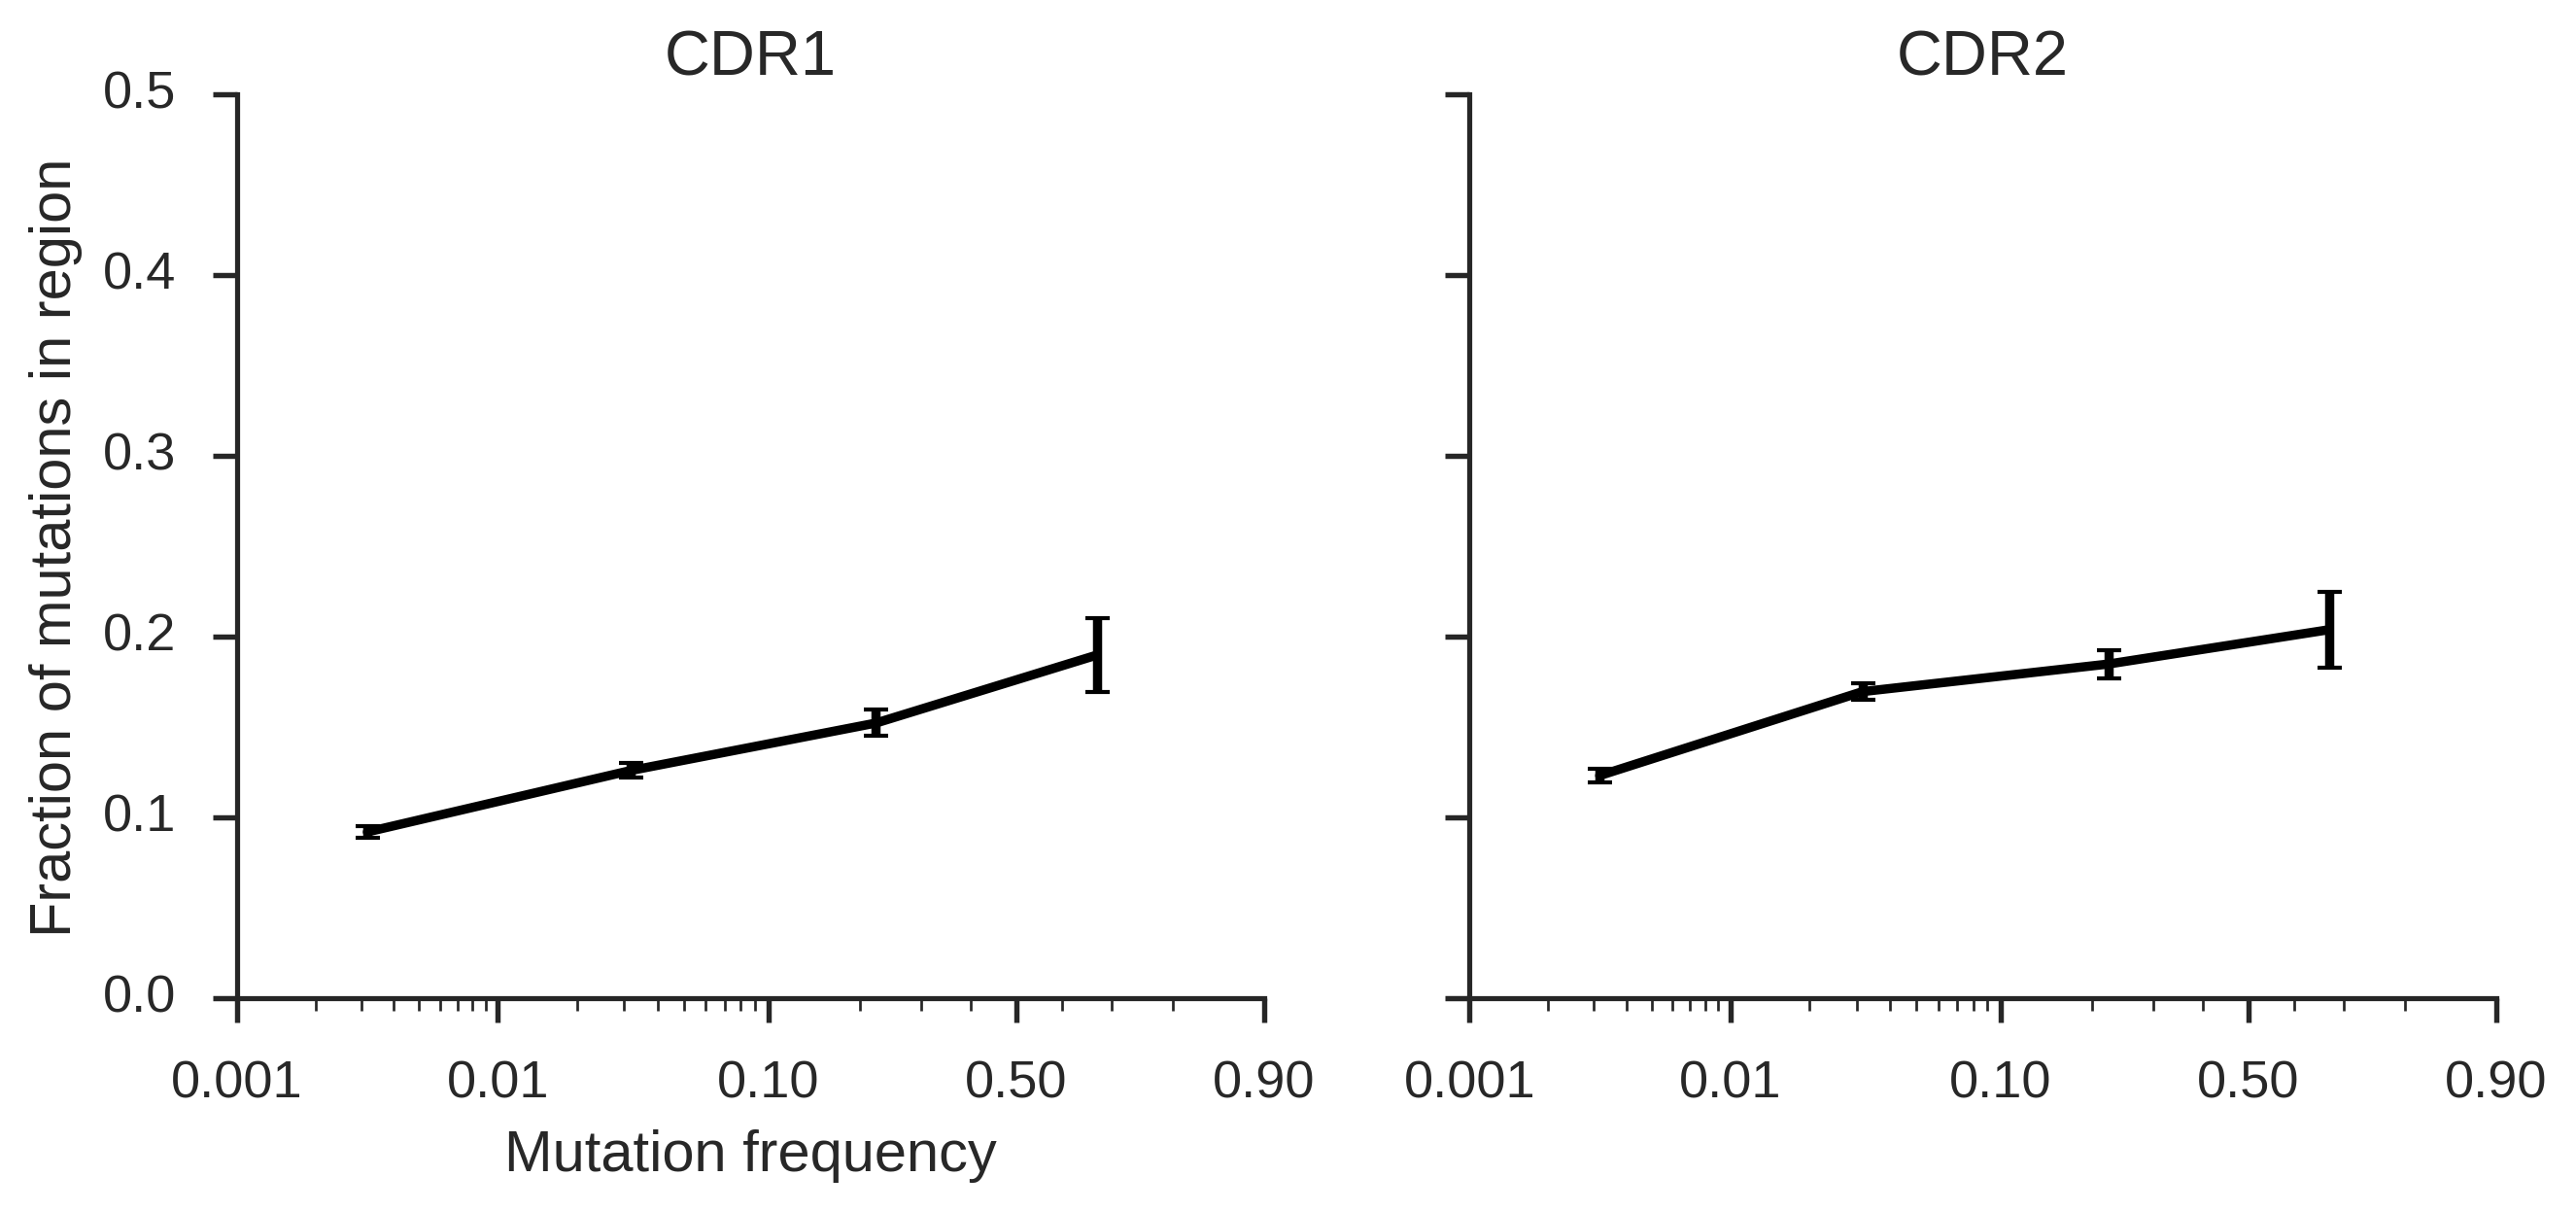

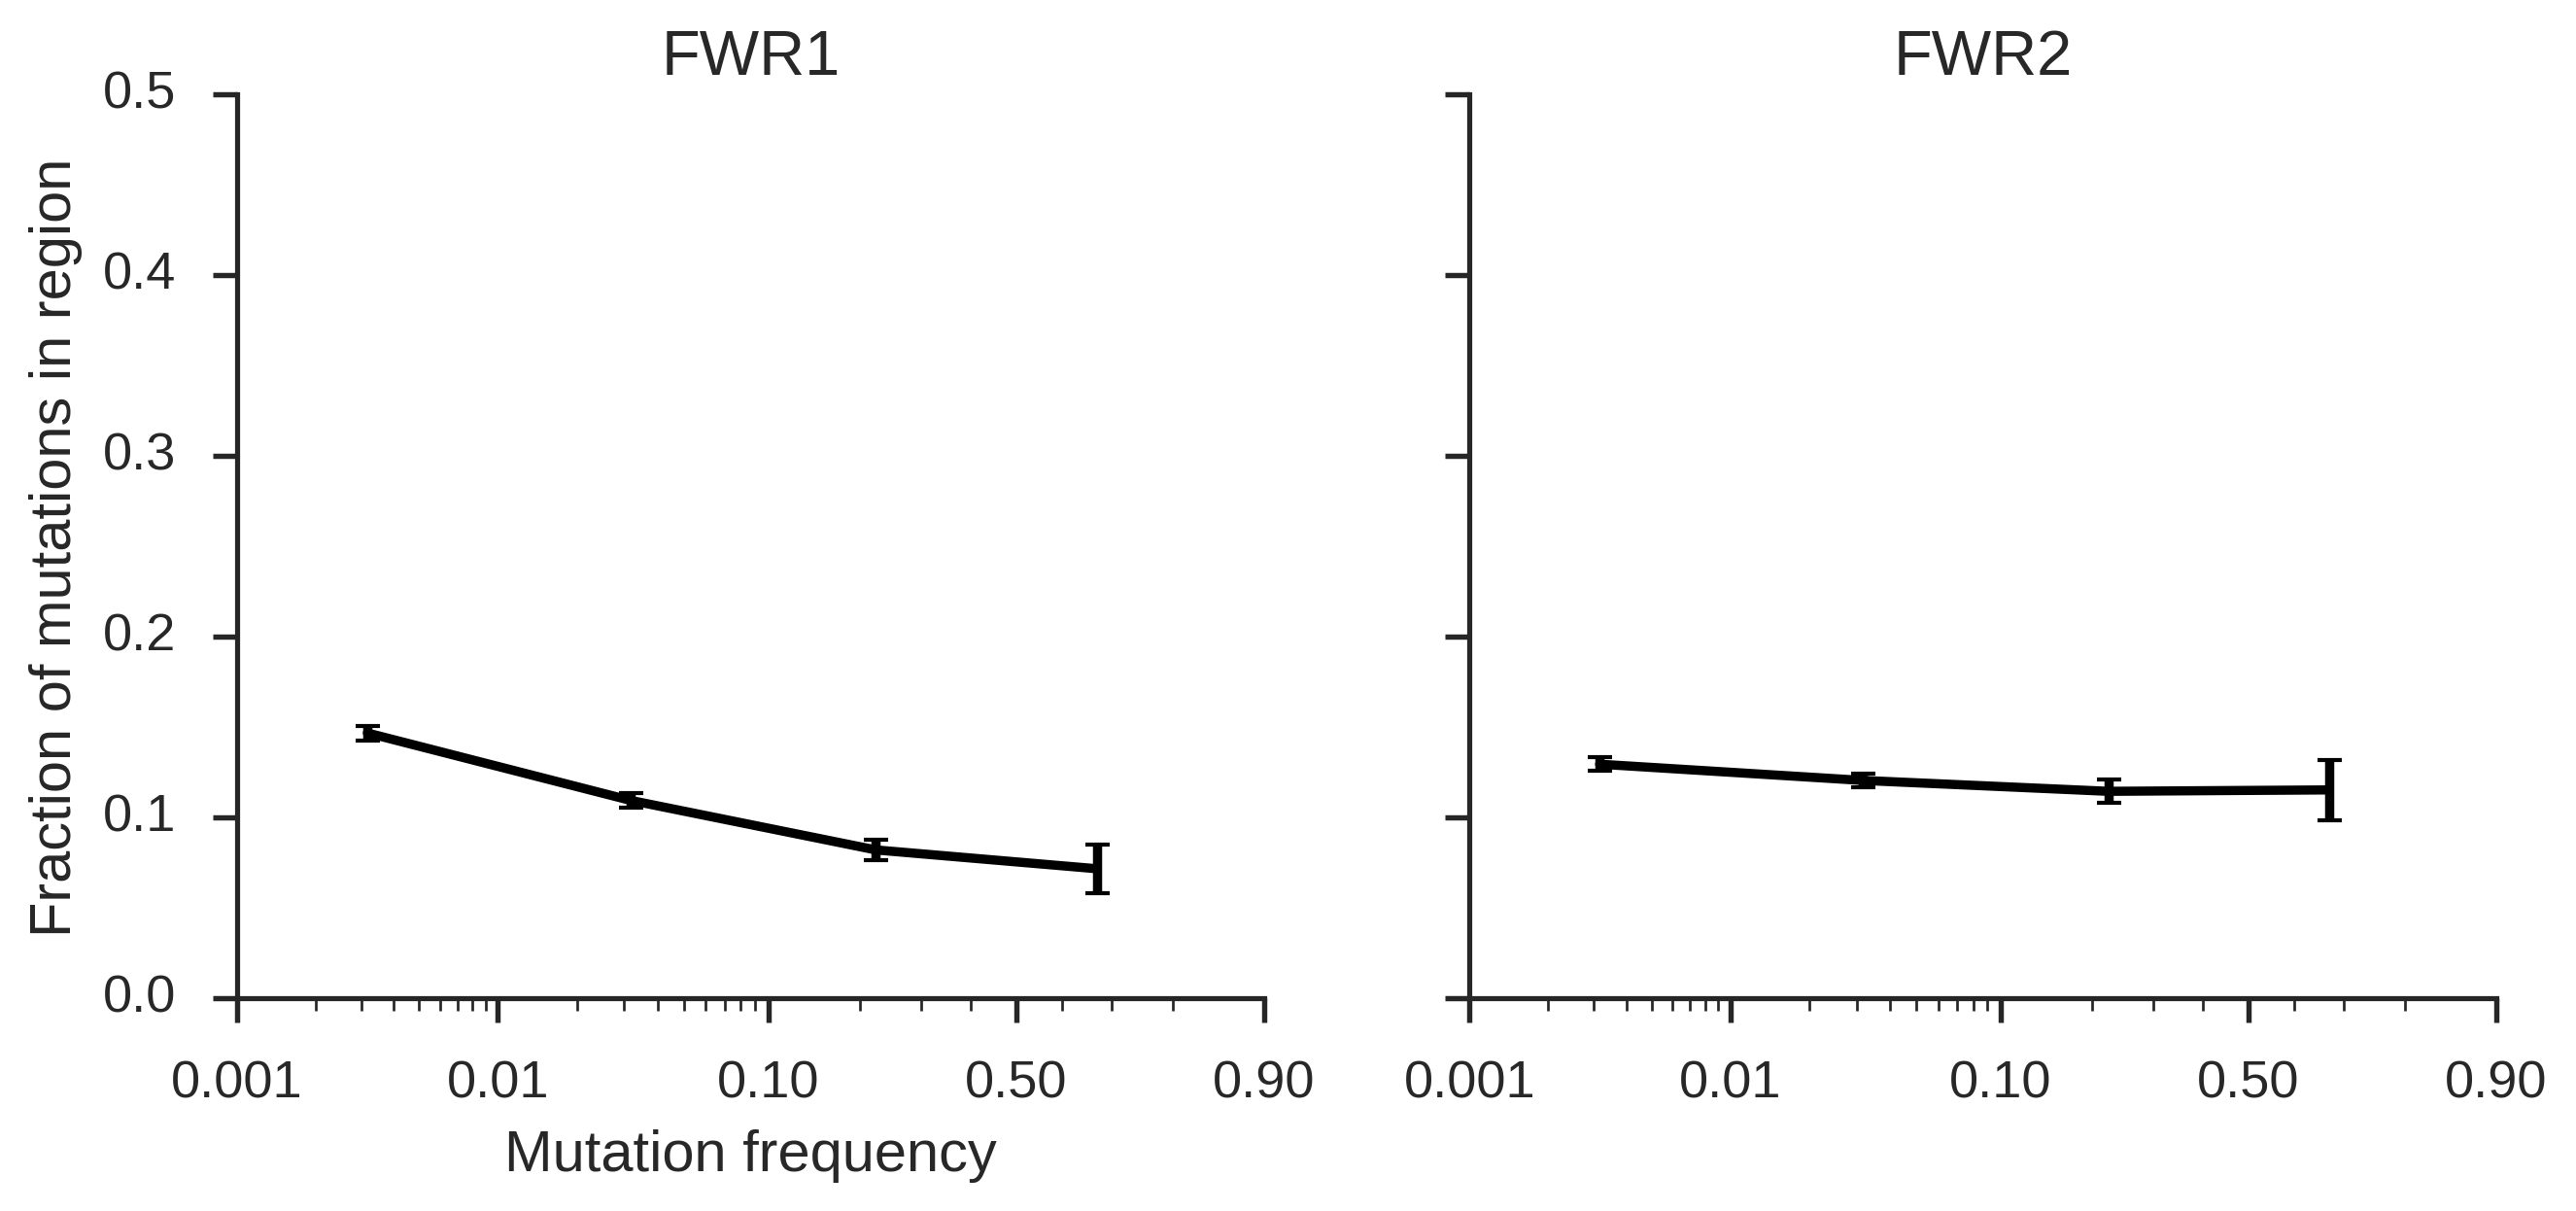

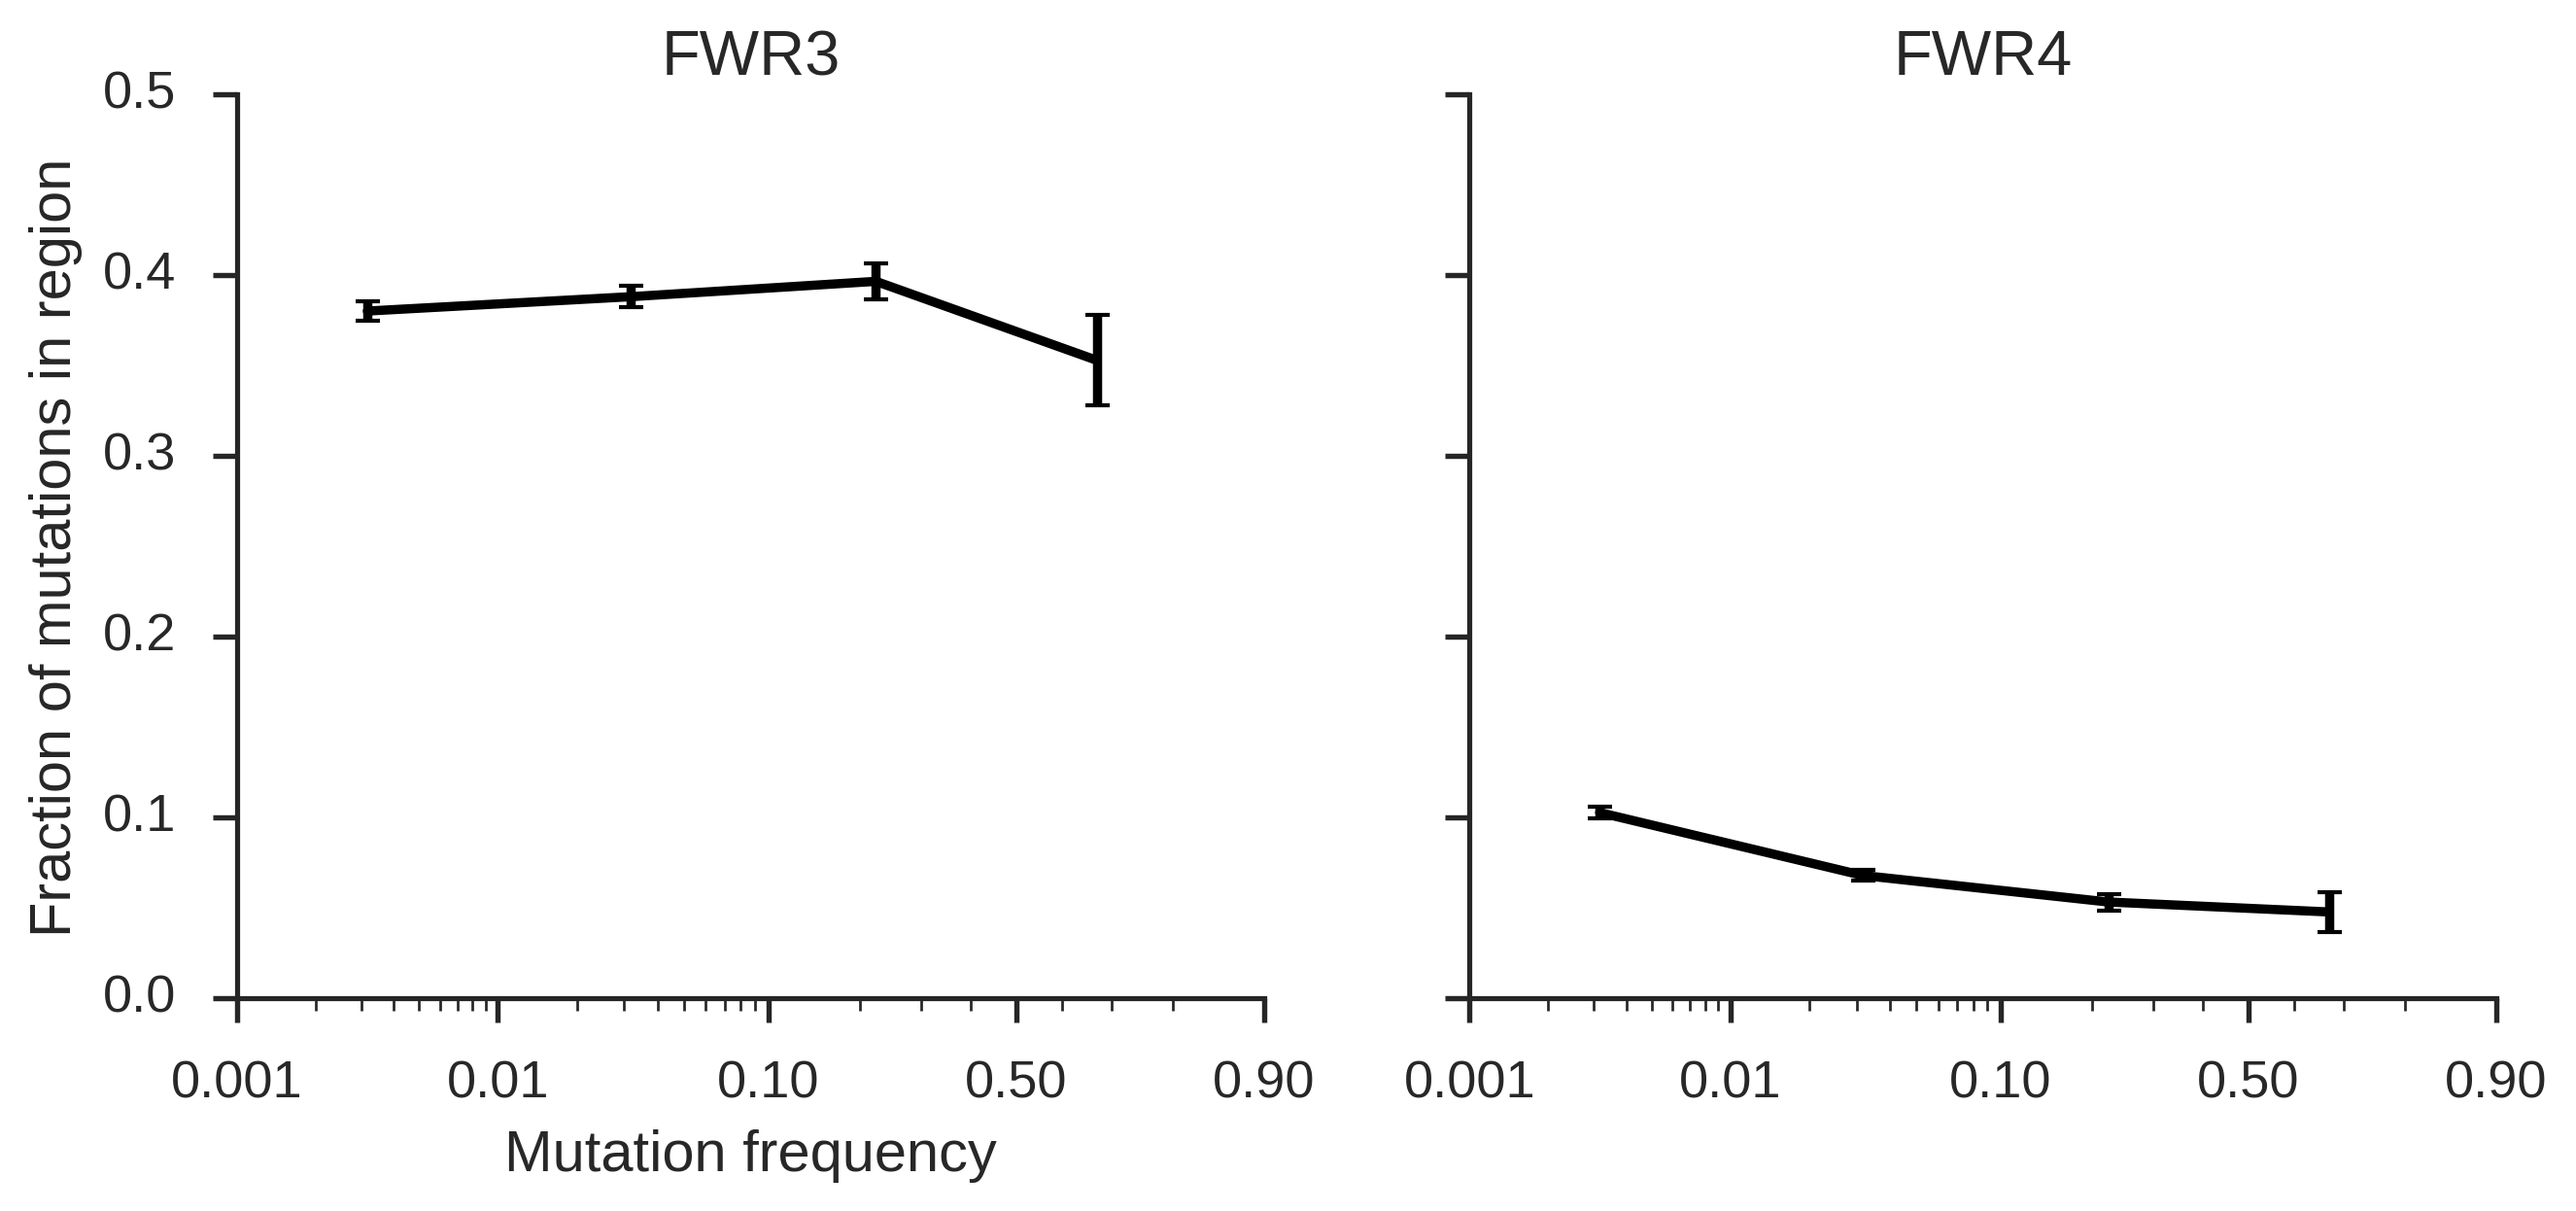

In [32]:
# Separate plots for CDR and FWR

my_regions = ["CDR1", "CDR2"]
fig, axes = plt.subplots(1, len(my_regions), figsize=(5*len(my_regions),4), sharey=True)
for region, ax in zip(my_regions, axes):
    myUpper = df_normed_pretty_ciUpper[region]
    myLower = df_normed_pretty_ciLower[region]
    (_, caps, _) = ax.errorbar(df_normed_pretty[region].index, df_normed_pretty[region], yerr=[myLower, myUpper],
                               color="k", fmt="-o", capthick=1, capsize=3, markersize=1)
    ax.set_xscale('logit', p_min=1e-5)
    ax.set_xlim(1e-3, 0.9)
    ax.set_ylim([0,0.5])
    ax.set_title(region)
    sns.despine()
axes[0].set_xlabel("Mutation frequency")
axes[0].set_ylabel("Fraction of mutations in region")
save_figure(fig, "SFS_Bulk_MutationRegions_CDR1_CDR2", output_dir, output_suffix, output_formats, savefig_args)

my_regions = ["FWR1", "FWR2"]
fig, axes = plt.subplots(1, len(my_regions), figsize=(5*len(my_regions),4), sharey=True)
for region, ax in zip(my_regions, axes):
    myUpper = df_normed_pretty_ciUpper[region]
    myLower = df_normed_pretty_ciLower[region]
    (_, caps, _) = ax.errorbar(df_normed_pretty[region].index, df_normed_pretty[region], yerr=[myLower, myUpper],
                               color="k", fmt="-o", capthick=1, capsize=3, markersize=1)
    ax.set_xscale('logit', p_min=1e-5)
    ax.set_xlim(1e-3, 0.9)
    ax.set_ylim([0,0.5])
    ax.set_title(region)
    sns.despine()
axes[0].set_xlabel("Mutation frequency")
axes[0].set_ylabel("Fraction of mutations in region")
save_figure(fig, "SFS_Bulk_MutationRegions_FWR1_FWR2", output_dir, output_suffix, output_formats, savefig_args)

my_regions = ["FWR3", "FWR4"]
fig, axes = plt.subplots(1, len(my_regions), figsize=(5*len(my_regions),4), sharey=True)
for region, ax in zip(my_regions, axes):
    myUpper = df_normed_pretty_ciUpper[region]
    myLower = df_normed_pretty_ciLower[region]
    (_, caps, _) = ax.errorbar(df_normed_pretty[region].index, df_normed_pretty[region], yerr=[myLower, myUpper],
                               color="k", fmt="-o", capthick=1, capsize=3, markersize=1)
    ax.set_xscale('logit', p_min=1e-5)
    ax.set_xlim(1e-3, 0.9)
    ax.set_ylim([0,0.5])
    ax.set_title(region)
    sns.despine()
axes[0].set_xlabel("Mutation frequency")
axes[0].set_ylabel("Fraction of mutations in region")
save_figure(fig, "SFS_Bulk_MutationRegions_FWR3_FWR4", output_dir, output_suffix, output_formats, savefig_args)